# Howto

Original implementation: https://github.com/sveinn-steinarsson/flot-downsample

Downloaded CSV from lttp-numpy repo at https://git.sr.ht/~javiljoen/lttb-numpy/tree/master/item/tests/timeseries.csv (added to this repo as well)


This repo by Charl P. Botha https://charlbotha.com/

## Quickstart

Setup virtual environment with required packages:

```shell
poetry install
```

Open this notebook with vscode or jupyter, then go through the cells, or skip straight to the last cell [Bench all of the implementations](#bench-all-of-the-implementations).


## Load data and init

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("timeseries.csv")
tseries = df.values

x = tseries[:,0]
y = tseries[:,1]

# Make tseries C-contiguous
tseries = np.copy(df.values, order='C')

THRESHOLD = 250

## lttbc: C + numpy version by dgoeries

See https://github.com/dgoeries/lttbc

Super neat numpy-API implementation in C

<AxesSubplot: >

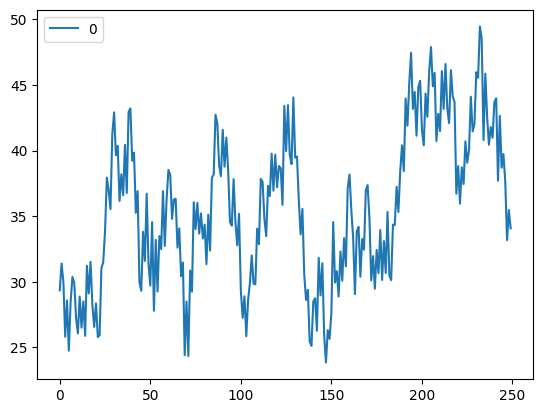

In [2]:
import lttbc

nx, ny = lttbc.downsample(x, y, THRESHOLD)

pd.DataFrame(ny).plot()

In [3]:
%%timeit
down_x, down_y = lttbc.downsample(x, y, THRESHOLD)

8.79 µs ± 85.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## lttb-numpy by javiljoen

See https://git.sr.ht/~javiljoen/lttb-numpy

<AxesSubplot: >

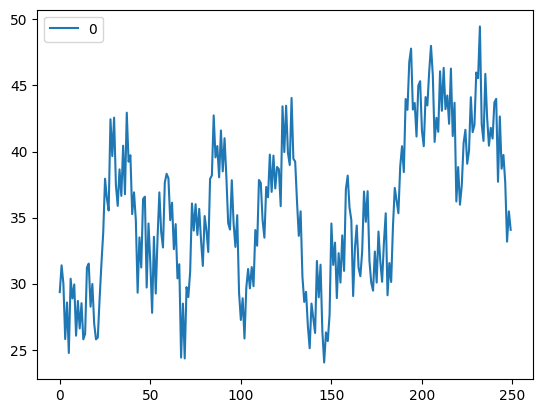

In [4]:
import lttb

# No input validation:
small_data = lttb.downsample(tseries, n_out=THRESHOLD, validators=[])

pd.DataFrame(small_data[:,1]).plot()

In [5]:
%%timeit
lttb.downsample(tseries, n_out=THRESHOLD, validators=[])

2.98 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## lttb-numpy by javiljoen — slightly modified and Pythran compiled

See https://github.com/serge-sans-paille/pythran

In [6]:
%%bash
pythran lttb_pt.py

<AxesSubplot: >

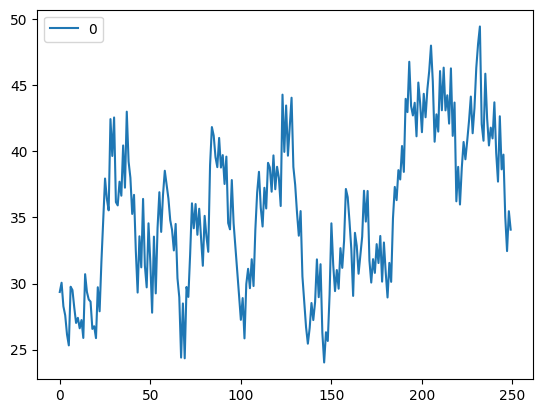

In [7]:
import lttb_pt

# No input validation:
small_data = lttb_pt.downsample(tseries, THRESHOLD)

pd.DataFrame(small_data[:,1]).plot()

In [8]:
%%timeit
lttb.downsample(tseries, n_out=THRESHOLD, validators=[])

3.06 ms ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## pylttb by dexter 2206

<AxesSubplot: >

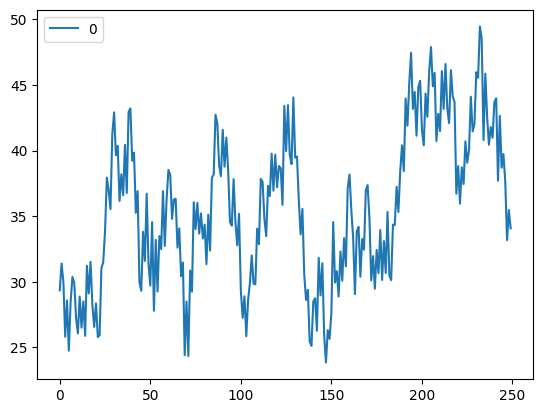

In [9]:
# https://github.com/dexter2206/pylttb
import pylttb

down_x, down_y = pylttb.lttb(x, y, THRESHOLD)

pd.DataFrame(down_y).plot()

In [10]:
%%timeit
pylttb.lttb(x, y, THRESHOLD)

3 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Working cython by cpbotha

About 10 to 15% slower than lttbc, but still quite fast.

In [11]:
# we use pyximport here for experimentation

import pyximport
pyximport.install()
import lttbcy

In [12]:
print(lttbcy)

<module 'lttbcy' from '/home/stefan/src/lttb-bench/lttbcy.cpython-310-x86_64-linux-gnu.so'>


In [13]:
%%timeit
lttbcy.downsample(x, y, THRESHOLD)

10.3 µs ± 117 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


<AxesSubplot: >

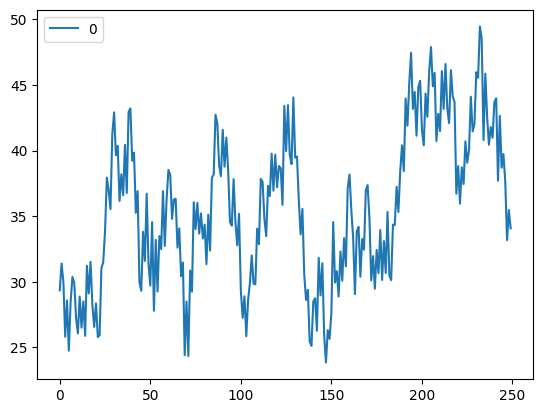

In [14]:
import pandas as pd
down_x, down_y = lttbcy.downsample(x,y,THRESHOLD)
pd.DataFrame(down_y).plot()

<AxesSubplot: >

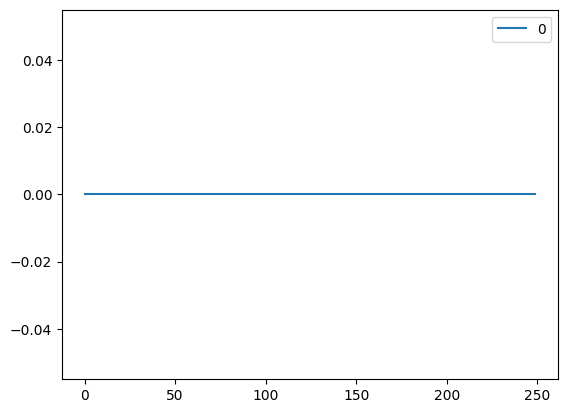

In [15]:
# check that results are identical to lttbc
pd.DataFrame(down_y - ny).plot()

## Continuation of non-working line profiling

In [16]:
#Load Robert Kern's line profiler
%load_ext line_profiler
import line_profiler

In [21]:
#Print profiling statistics using the `line_profiler` API

profile = line_profiler.LineProfiler(lttbcy.downsample)
profile.runcall(lttbcy.downsample, x, y, THRESHOLD)
profile.print_stats()

Timer unit: 1e-09 s



In [24]:
%lprun -f lttbcy.downsample lttbcy.downsample(x,y,THRESHOLD)

## Test the pyx version

see `setup.py`

<module 'lttbcy' from '/home/stefan/src/lttb-bench/lttbcy.cpython-310-x86_64-linux-gnu.so'>


<AxesSubplot: >

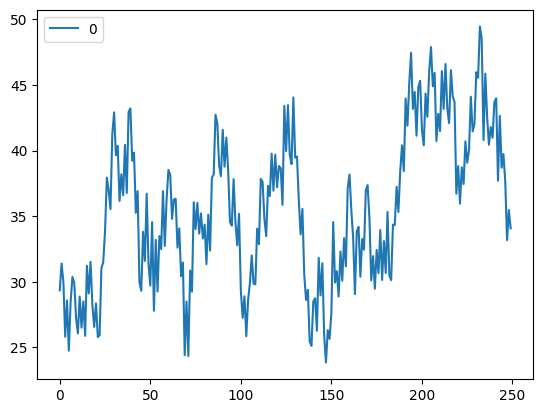

In [25]:
import pandas as pd
import lttbcy
# make sure this is the built version, and not the pyximported one
print(lttbcy)
down_x, down_y = lttbcy.downsample(x,y,THRESHOLD)
pd.DataFrame(down_y).plot()

## Bench all of the implementations

In [29]:
setup = """
import pandas as pd
import numpy as np

df = pd.read_csv('timeseries.csv')
tseries = df.values

x = tseries[:,0]
y = tseries[:,1]

# Make tseries contiguous
tseries = np.copy(tseries, order='C')

THRESHOLD = 250
"""

print("lttbc")
!python -m timeit -s "$setup" -s "import lttbc" "lttbc.downsample(x, y, THRESHOLD)"

print("\nlttbc-numpy")
!python -m timeit -s "$setup" -s "import lttb" "lttb.downsample(tseries, n_out=THRESHOLD, validators=[])"

print("\npylttb")
!python -m timeit -s "$setup" -s "import pylttb" "pylttb.lttb(x, y, THRESHOLD)"

print("\nlttb-cython")
setup_pyx = """import pyximport
pyximport.install()
import lttbcy"""
!python -m timeit -s "$setup" -s "$setup_pyx" "lttbcy.downsample(x, y, THRESHOLD)"

print("\nlttb-pythran")
!python -m timeit -s "$setup" -s "import lttb_pt" "lttb_pt.downsample(tseries, THRESHOLD)"

lttbc
50000 loops, best of 5: 9.11 usec per loop

lttbc-numpy
100 loops, best of 5: 2.9 msec per loop

pylttb
100 loops, best of 5: 3.12 msec per loop

lttb-cython
20000 loops, best of 5: 10.1 usec per loop

lttb-pythran
10000 loops, best of 5: 23.2 usec per loop
